In [4]:
from ipywidgets import interact
import numpy as np
from matplotlib import pyplot as plt
import math
import numpy as np
import hashlib
import scipy.stats as stats
import json 
import nbinteract as nbi


In [5]:
def square(x):
    return x * x

In [6]:
interact(square, x=10);


interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [7]:
class CountMinSketch:
    def __init__(self, eps, delta):
        self.eps = eps
        self.delta = delta
        self.w = math.ceil(np.exp(1) / eps)
        self.d = math.ceil(np.log(1 / delta))
        self.tables = np.zeros((self.d, self.w))
        self.backup = {}

    def compute_hash(self, value, table_no):
        fn = hashlib.md5()
        inp = str(value) + str(0) + str(table_no)
        fn.update(inp.encode())
        out = int(fn.hexdigest(), 16)
        return out % self.w

    def count(self, value):
        if str(value) in self.backup: 
            self.backup[str(value)] = self.backup[str(value)] + 1
        else:
            self.backup[str(value)] = 1
        for i in range(self.d):
            j = self.compute_hash(value, i)
            self.tables[i][j] = self.tables[i][j] + 1

    def estimate(self, value):
        ests = []
        for i in range(self.d):
            j = self.compute_hash(value, i)
            ests.append(self.tables[i][j])
        return min(ests)

    def real_estimate(self, value):
        if str(value) in self.backup: return self.backup[str(value)]
        return -1

    def compute_size(self):
        size = 0
        for key in self.backup:
            size += abs(self.backup[key])
        return size

    def save_counts(self, count_filename='counts.txt', actual_filename='backups.txt'):
        np.savetxt(count_filename, self.tables)
        with open(actual_filename, 'w') as fp: json.dump(self.backup, fp)

    def load_counts(self, count_filename='counts.txt', actual_filename='backups.txt'):
        with open(actual_filename, 'r') as fp: 
            temp = json.load(fp)
            self.backup = temp
        self.tables = np.loadtxt(count_filename)

In [21]:
def load_data(cms, data):
  for el in data:
    cms.count(el)

In [123]:
def generate_sample(n=1000, dist='uniform', loc=0, scale=100, lambda_=5, s=100):
    if dist == 'uniform':
        float_sample = stats.uniform.rvs(loc, scale, n)
        return [int(el) for el in float_sample]
    if dist == 'zipf':
        float_sample = stats.zipf.rvs(a, size=n)
        return [(el) for el in float_sample]
    if dist == 'exp':
        float_sample = planck.rvs(lambda_, size=n)
        return [int(el) for el in float_sample]
    if dist == 'lognorm':
        float_sample = lognorm.rvs(s=s, size=n)
        return [int(el) for el in float_sample]
    if dist == 'geometric':
        float_sample =  geom.rvs(p, size=n)
        return [int(el) for el in float_sample]
    elif dist == 'normal':
        float_sample = stats.norm.rvs(loc, scale, n)
        return [int(el) for el in float_sample]
    else:
        return -1

In [124]:
# VISUALIZE ERROR PROBABILITY VS DELTA

# compute empirical probability of error exceeding the threshold
def compute_error_prob(cms, data, n):
  err = []
  for el in data:
    err.append(cms.estimate(el) - cms.real_estimate(el))
  avg_err = sum(err) / len(err)
  max_err = max(err)
  exceed = 0
  for el in err:
    if el > cms.eps * n:
      exceed += 1
  p = exceed / len(err)
  return p, avg_err, max_err, err

# run experiments on 10 values of delta interpolated between (min_delta, max_delta) and compute array of corresponding error probabilities
def error_prob_vs_delta(n=100000, eps=0.4, min_delta=0.01, max_delta=0.1):
  deltas = np.linspace(min_delta, max_delta, 10).tolist()
  # deltas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
  ps = []
  for delta in deltas:
    probs = 0
    # Average probabilities across 3 trials
    for i in range(3):
      cms = CountMinSketch(eps, delta)
      dt = generate_sample(n)
      load_data(cms, dt)
      p, avg_err, max_err, err = compute_error_prob(cms, dt, n)
      probs += p
    probs /= 3
    ps.append(probs)
  return deltas, ps

# graphing helper function
def graph_error_prob_vs_delta(deltas, ps, filename="p_vs_delta.png"):
  plt.scatter(deltas, ps)
  plt.show()

# actual code to run experiment:
# deltas, ps = error_prob_vs_delta()
# graph_error_prob_vs_delta(deltas, ps)

Average Error: 0.312
Maximum Error: 12.0
Acceptable Threshold: 10.0
Proportion of Errors Exceeding Threshold: 0.017


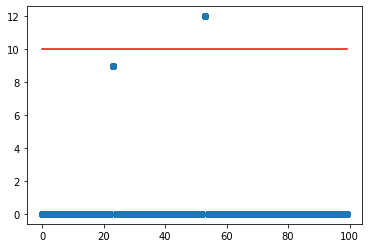

In [125]:
# VISUALIZE HOW ERROR DISTRIBUTION CHANGES WITH EPS, DELTA, N ON UNIFORM DATA
eps = 0.01
delta = 0.05
n = 1000
threshold = eps * n
sample = generate_sample(n=n)

cms = CountMinSketch(eps, delta)
load_data(cms, sample)

p, avg_err, max_err, err = compute_error_prob(cms, sample, n)

print("Average Error: " + str(avg_err))
print("Maximum Error: " + str(max_err))
print("Acceptable Threshold: " + str(threshold))
print("Proportion of Errors Exceeding Threshold: " + str(p))

plt.scatter(sample, err)
plt.plot([min(sample), max(sample)], [threshold, threshold], color='red')
plt.show()

In [126]:
def generate_sample(n=1000, dist='uniform', loc=0, scale=10000, lambda_=5, s=1, a=6.5):
    print(dist)
    if dist == 'uniform':
        float_sample = stats.uniform.rvs(loc, scale, n)
        return [int(el) for el in float_sample]
    if dist == 'zipf':
        float_sample = stats.zipf.rvs(a, size=n)
        return [int(el) for el in float_sample]
    if dist == 'exp':
        float_sample = stats.planck.rvs(lambda_, size=n)
        return [int(el) for el in float_sample]
    if dist == 'lognorm':
        float_sample = stats.lognorm.rvs(s=s, size=n)
        return [int(el) for el in float_sample]
    if dist == 'geometric':
        float_sample =  stats.geom.rvs(p, size=n)
        return [int(el) for el in float_sample]
    elif dist == 'normal':
        float_sample = stats.norm.rvs(loc, scale, n)
        return [int(el) for el in float_sample]
    else:
        return -1

In [127]:
def plot_uniform(sample, eps, delta):
    print(eps, delta)
    eps = float(eps)
    delta = float(delta)
    # VISUALIZE HOW ERROR DISTRIBUTION CHANGES WITH EPS, DELTA, N ON UNIFORM DATA
    threshold = eps * n
    #sample = generate_sample(n=n)

    cms = CountMinSketch(eps, delta)
    load_data(cms, sample)

    p, avg_err, max_err, err = compute_error_prob(cms, sample, n)

    print("Average Error: " + str(avg_err))
    print("Maximum Error: " + str(max_err))
    print("Acceptable Threshold: " + str(threshold))
    print("Proportion of Errors Exceeding Threshold: " + str(p))

    #plt.scatter(sample, err)
    #plt.plot([min(sample), max(sample)], [threshold, threshold], color='red')
    return err
    #plt.show()

In [133]:
n = 1000
#sample = generate_sample(n=n, dist="normal")


def get_sample(eps, delta, distribution, n): 
    return generate_sample(n=n, dist=distribution)



nbi.scatter(get_sample, plot_uniform, n=(1,2000), eps=(0.01,1, 0.01), delta=(0.01, 1, 0.01), distribution={'normal': "normal", 'zipf': 'zipf', 'uniform': 'uniform', 'exp':'exp', 'geometric':'geometric', 'lognorm':'lognorm'})


In [132]:
def hist_response_function(mean, sd, size=1000):
    '''
    Returns 1000 values picked at random from the normal
    distribution with the mean and SD given.
    '''
    print(mean, sd)
    return np.random.normal(loc=mean, scale=sd, size=1000)

In [130]:
nbi.scatter(hist_response_function, mean=(0, 10), sd=(0, 2.0, 0.2))


TypeError: scatter() missing 1 required positional argument: 'y_fn'

In [134]:
generate_sample(n=n, dist="zipf")

zipf


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
